In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

data = pd.read_csv('Company_Data.csv')

data = data.dropna()

numerical_features = ['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']

categorical_columns = ['ShelveLoc', 'Urban', 'US']

In [2]:
# Converting the target (Sales) variable into a categorical variable
sales_threshold = 8
data['Sales'] = data['Sales'].apply(lambda x: 'High' if x > sales_threshold else 'Low')

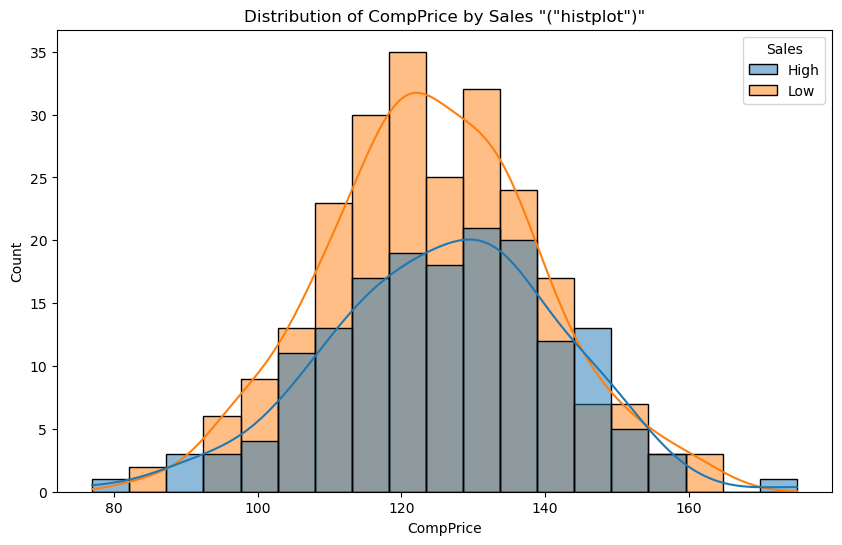

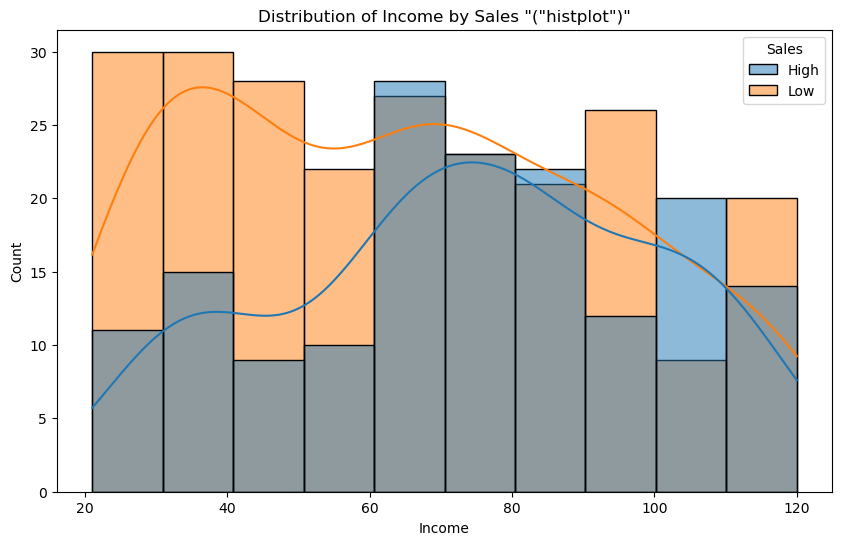

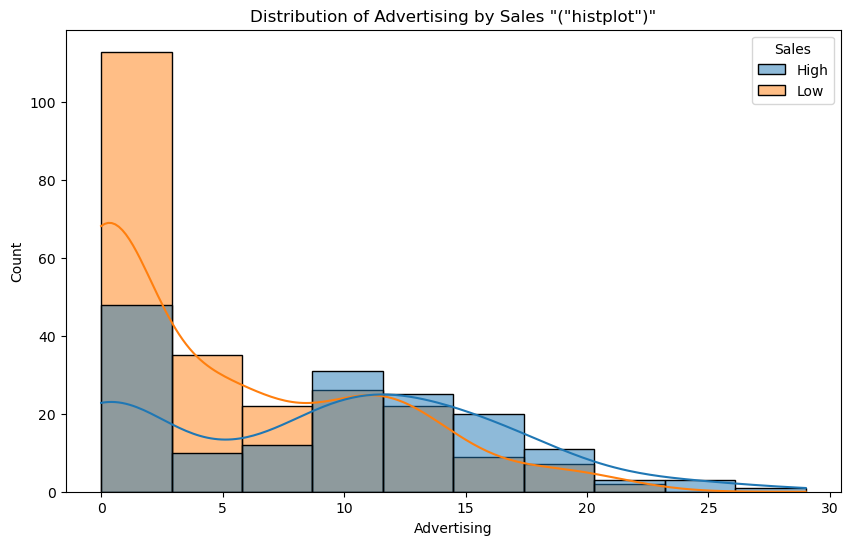

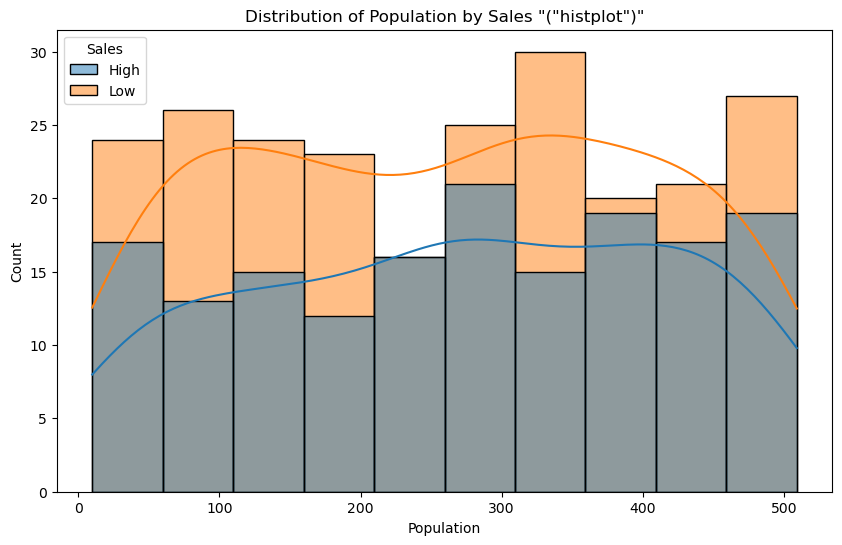

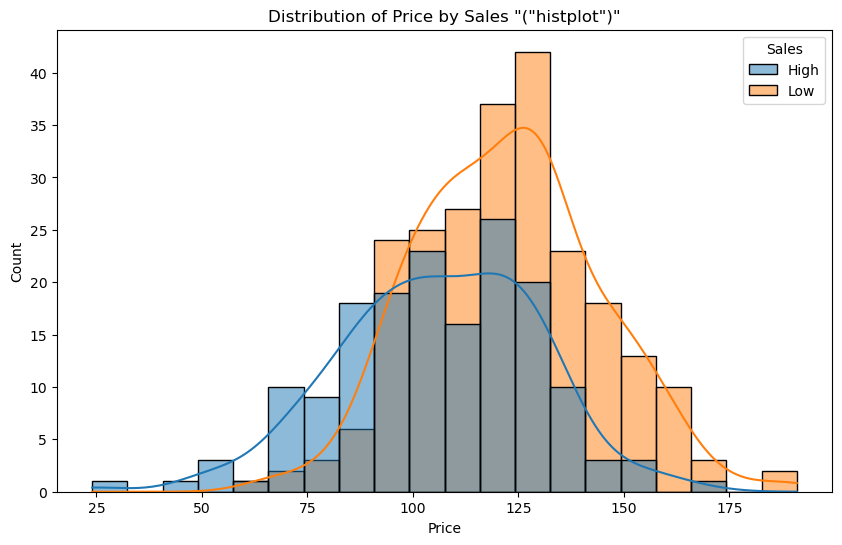

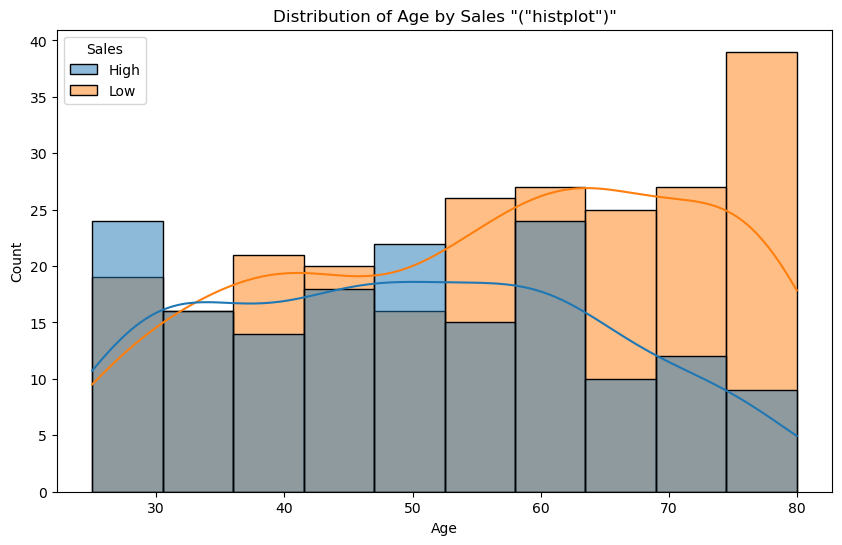

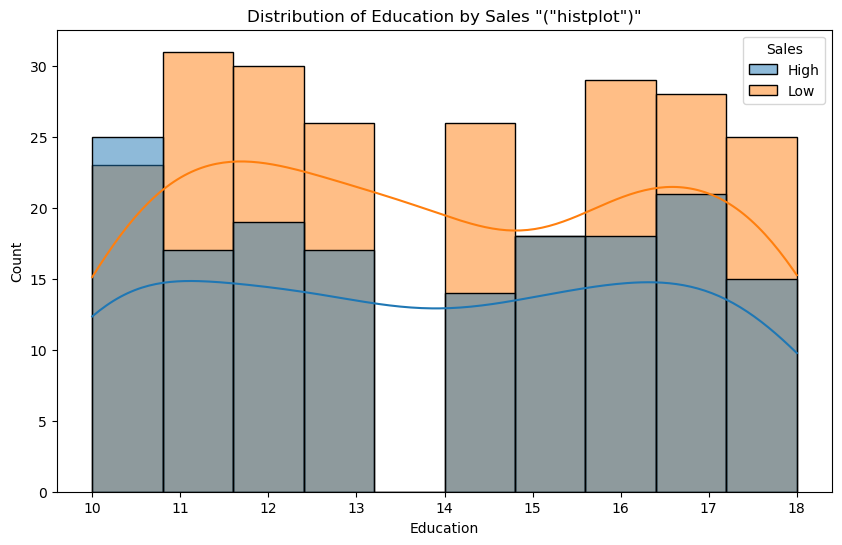

In [3]:
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=feature, hue='Sales', kde=True)
    plt.title(f'Distribution of {feature} by Sales "("histplot")"')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

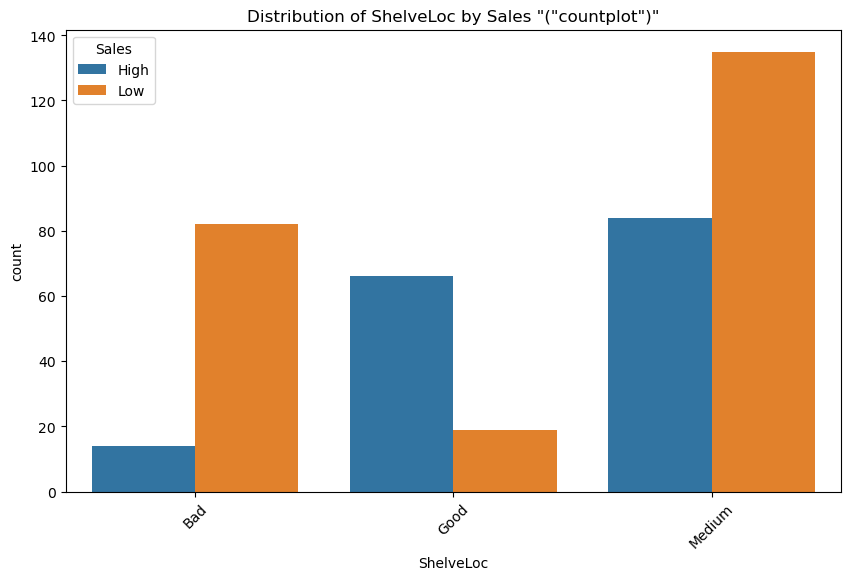

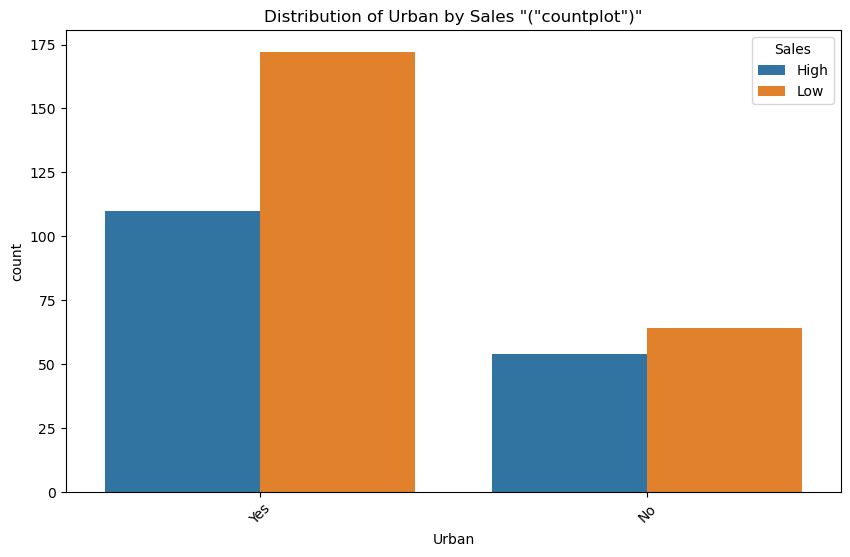

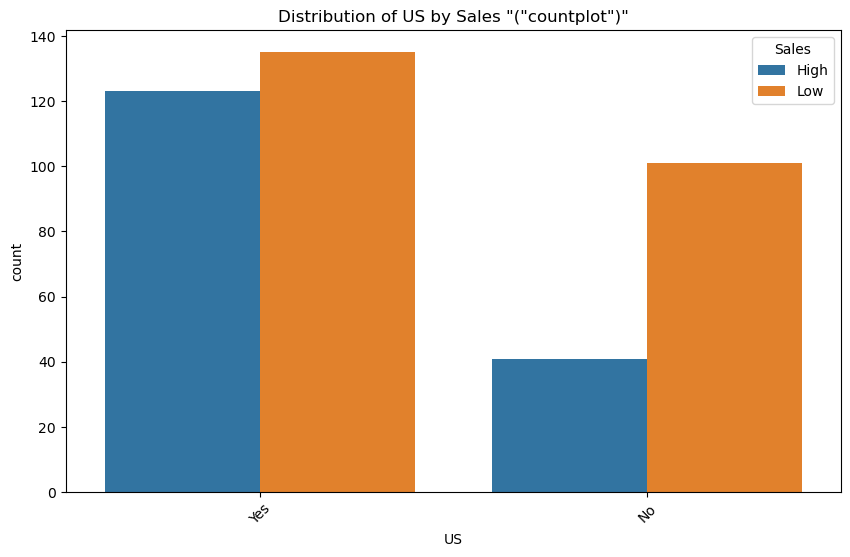

In [4]:
# Count Plots
for feature in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='Sales', data=data)
    plt.title(f'Distribution of {feature} by Sales "("countplot")"')
    plt.xticks(rotation=45)
    plt.show()

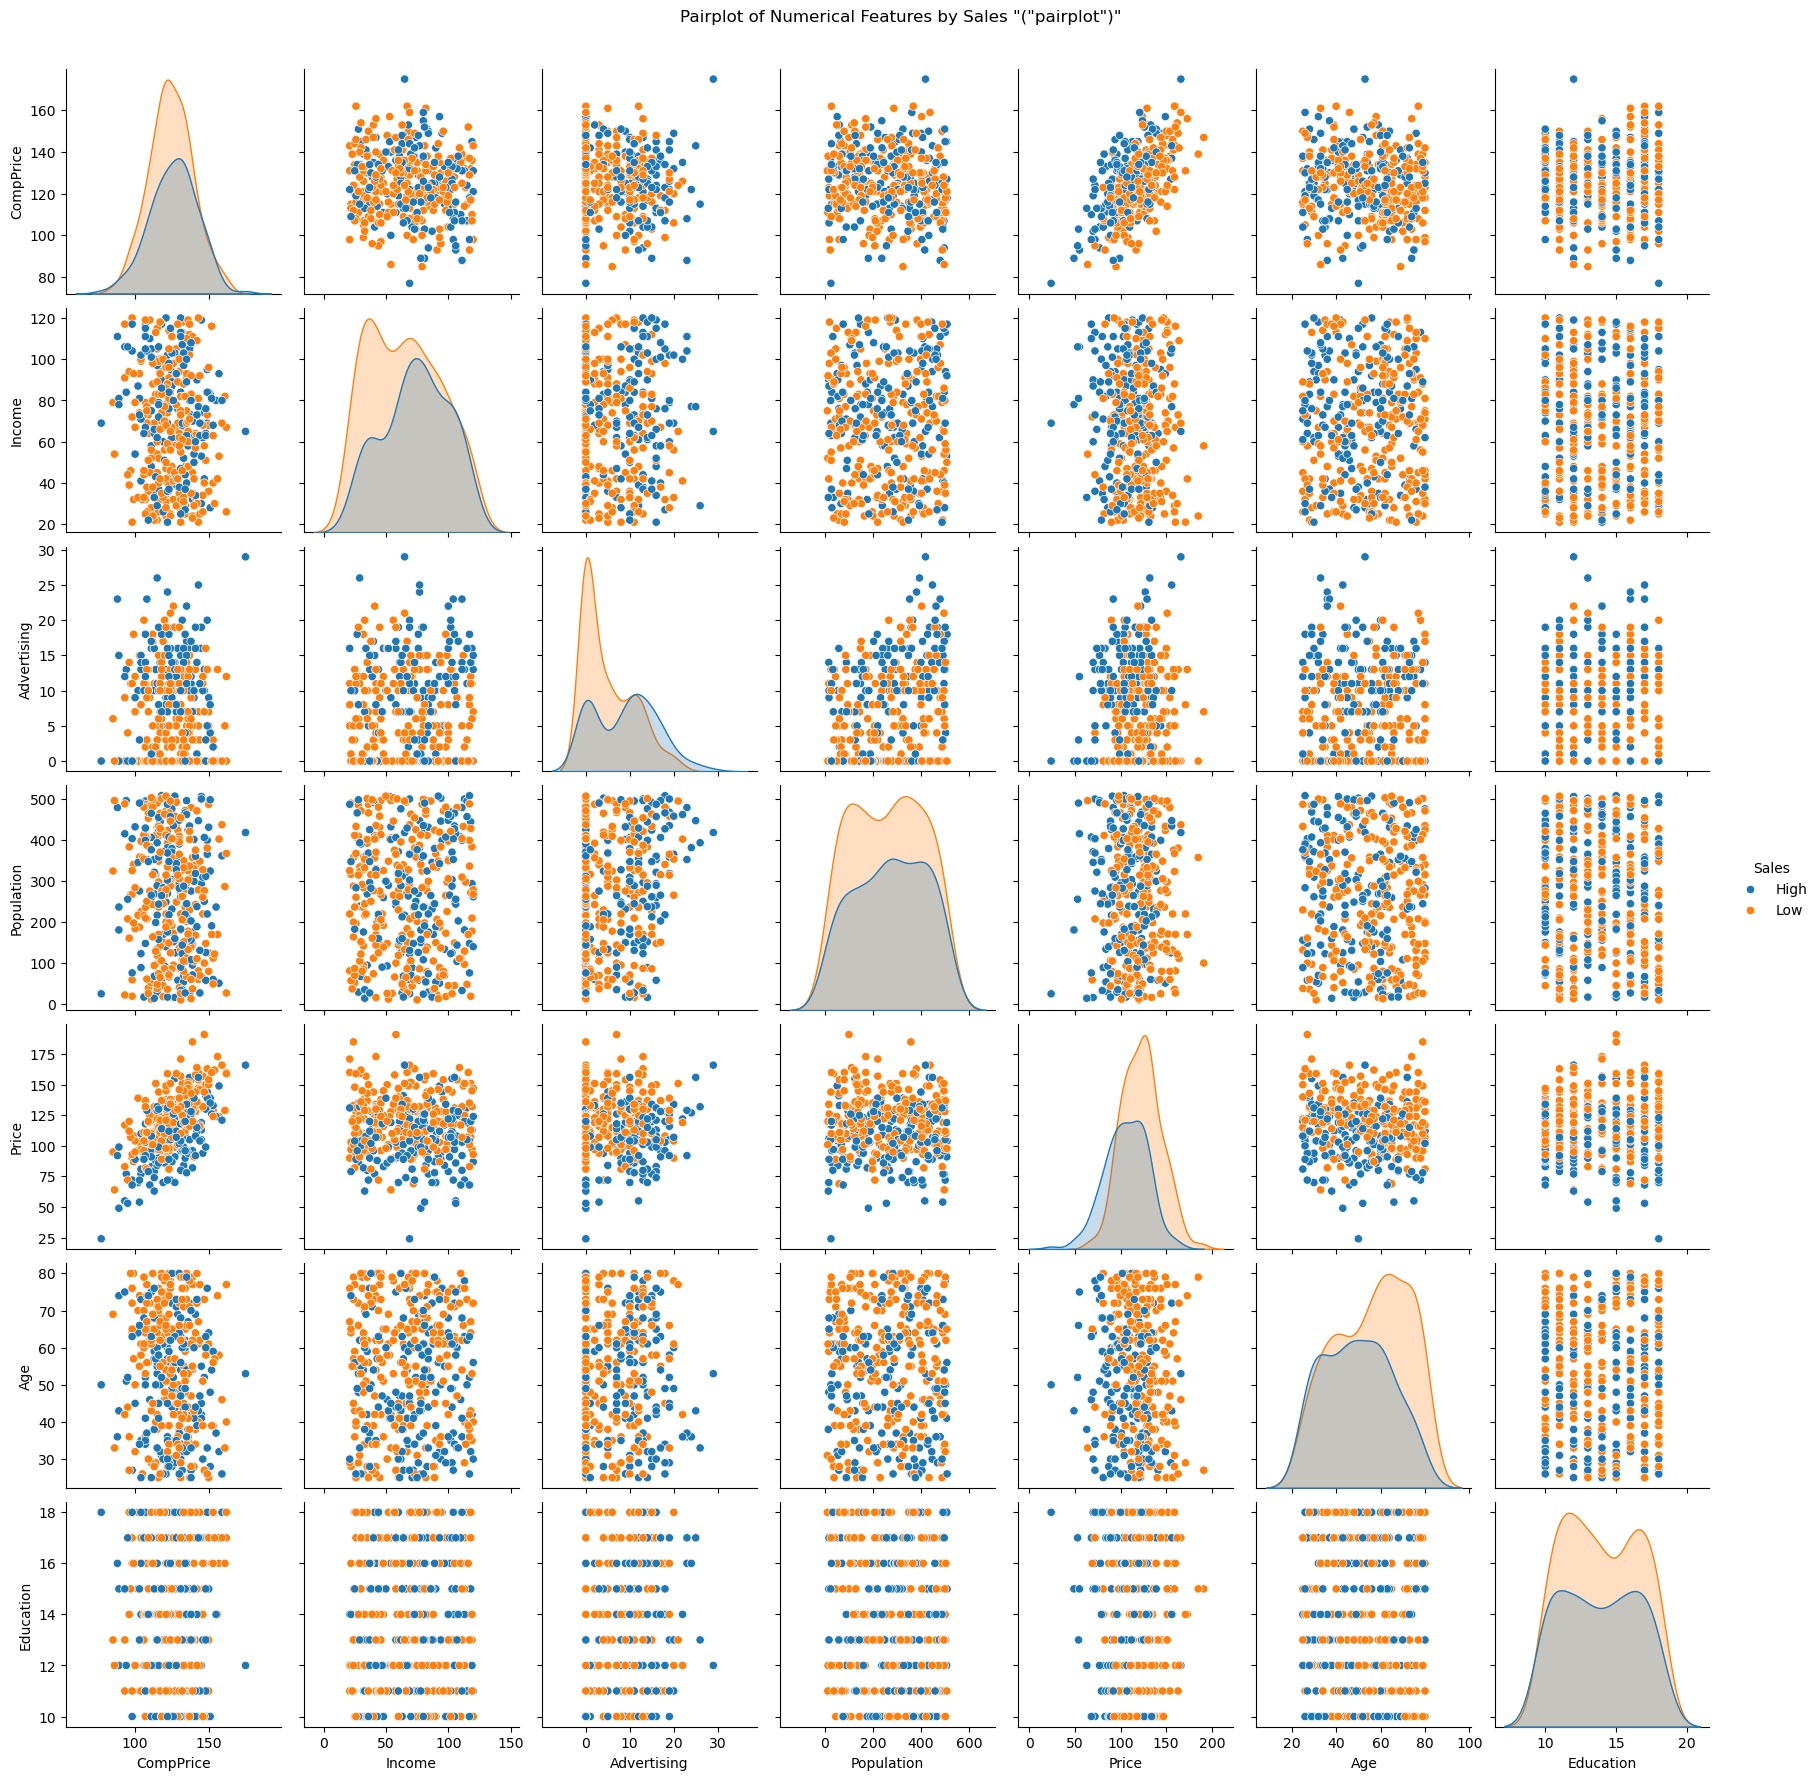

In [5]:
# Pairplot
sns.pairplot(data, hue='Sales', diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features by Sales "("pairplot")"', y=1.02)
plt.show()

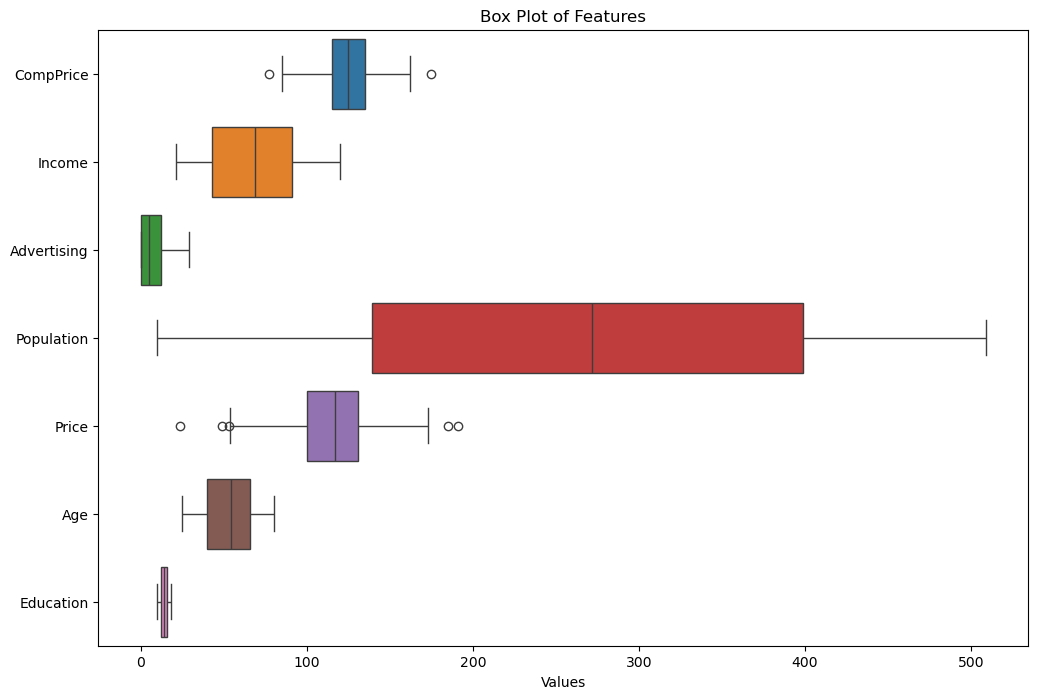

In [6]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, orient="h")
plt.title('Box Plot of Features')
plt.xlabel('Values')
plt.show()

In [7]:
def remove_outliers_iqr(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

# Remove outliers from combined_data
data = remove_outliers_iqr(data, numerical_features)

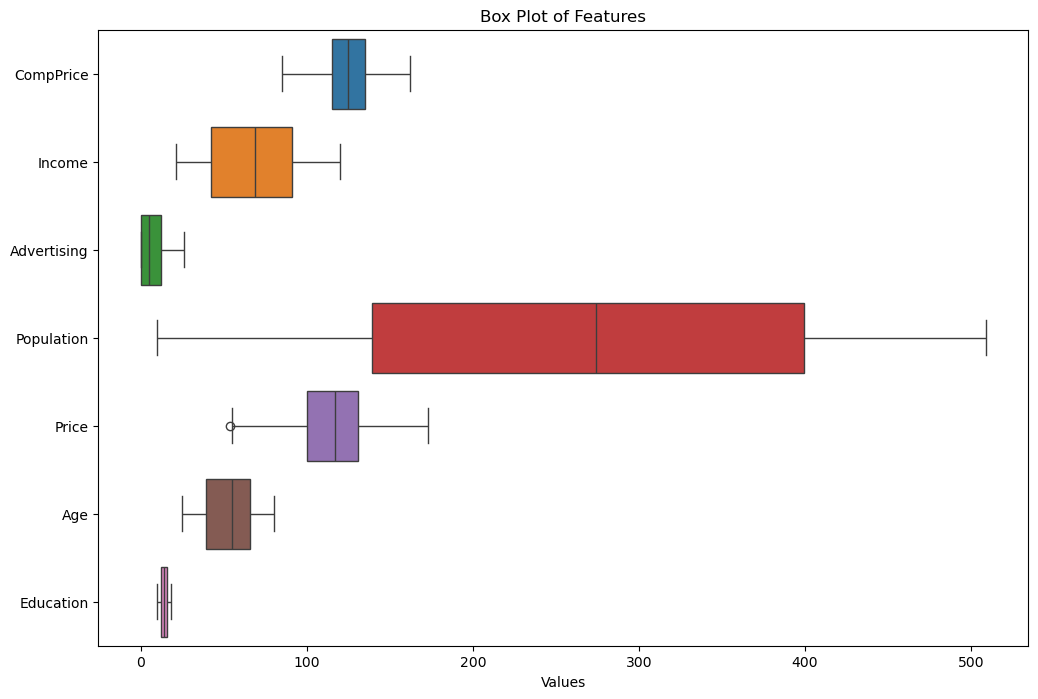

In [8]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, orient="h")
plt.title('Box Plot of Features')
plt.xlabel('Values')
plt.show()

In [9]:
# Data Pre-processing

# Convert categorical variables to numerical using Label Encoding
label_encoder = LabelEncoder()
data['ShelveLoc'] = data['ShelveLoc'].replace({'Good': 3, 'Medium': 2, 'Bad': 1})
data['Urban'] = label_encoder.fit_transform(data['Urban'])
data['US'] = data['US'].replace({'Yes': 1, 'No': 0})
#data['US'] = label_encoder.fit_transform(data['US'])

In [10]:
unique_counts_shelve_loc = data['ShelveLoc'].value_counts()
unique_counts_urban = data['Urban'].value_counts()
unique_counts_us = data['US'].value_counts()

print("Unique counts for 'ShelveLoc':")
print(unique_counts_shelve_loc)

print("\nUnique counts for 'Urban':")
print(unique_counts_urban)

print("\nUnique counts for 'US':")
print(unique_counts_us)

Unique counts for 'ShelveLoc':
ShelveLoc
2    215
1     95
3     84
Name: count, dtype: int64

Unique counts for 'Urban':
Urban
1    278
0    116
Name: count, dtype: int64

Unique counts for 'US':
US
1    256
0    138
Name: count, dtype: int64


In [11]:
# Separate features (independent variables) and target variable
X = data.drop('Sales', axis=1)
y = data['Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Undersampling with RandomUnderSampler
#undersampler = RandomUnderSampler(random_state=42)
#X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

In [13]:
unique_counts_us = y_train.value_counts()
print("\nUnique counts for 'US':")
print(unique_counts_us)


Unique counts for 'US':
Sales
Low     195
High    195
Name: count, dtype: int64


In [14]:
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

model = grid_search.best_estimator_

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [15]:
y_pred = model.predict(X_test)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)
print(f"Accuracy on the testing set: {accuracy:.2f}")

# Display the decision tree rules
tree_rules = export_text(model, feature_names=list(X.columns))
print("Decision Tree Rules:")
print(tree_rules)

Accuracy on the testing set: 0.71
Decision Tree Rules:
|--- Advertising <= 6.50
|   |--- ShelveLoc <= 1.50
|   |   |--- Education <= 12.50
|   |   |   |--- Advertising <= 2.50
|   |   |   |   |--- class: Low
|   |   |   |--- Advertising >  2.50
|   |   |   |   |--- class: Low
|   |   |--- Education >  12.50
|   |   |   |--- class: Low
|   |--- ShelveLoc >  1.50
|   |   |--- Age <= 63.50
|   |   |   |--- Price <= 104.50
|   |   |   |   |--- CompPrice <= 113.00
|   |   |   |   |   |--- Price <= 86.00
|   |   |   |   |   |   |--- class: High
|   |   |   |   |   |--- Price >  86.00
|   |   |   |   |   |   |--- class: Low
|   |   |   |   |--- CompPrice >  113.00
|   |   |   |   |   |--- Advertising <= 4.50
|   |   |   |   |   |   |--- class: High
|   |   |   |   |   |--- Advertising >  4.50
|   |   |   |   |   |   |--- class: High
|   |   |   |--- Price >  104.50
|   |   |   |   |--- Income <= 36.00
|   |   |   |   |   |--- class: Low
|   |   |   |   |--- Income >  36.00
|   |   |   |   |  

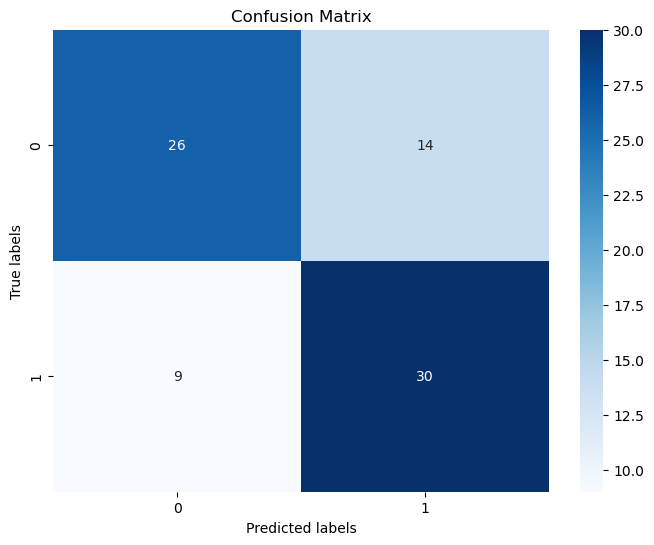

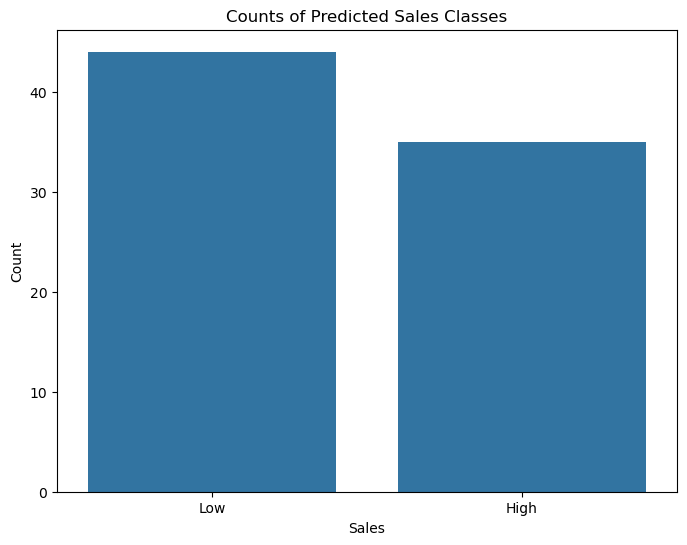

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Evaluation
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Prediction Analysis
# Counts of Predicted Sales Classes
X_test['Predicted_Sales'] = y_pred

plt.figure(figsize=(8, 6))
sns.countplot(x='Predicted_Sales', data=X_test)
plt.title('Counts of Predicted Sales Classes')
plt.xlabel('Sales')
plt.ylabel('Count')
plt.show()